This notebook will be testing different classification models and comparing them

In [73]:

import pandas as pd
import numpy as np
df = pd.read_csv('../data/raw/chris_sale.csv')
df.head()

,game_pk,at_bat_number,pitch_number,pitch_type,pitch_type_map,is_fastball,balls,strikes,outs_when_up,inning,...,away_score,bat_score,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,prev_pitch_1,prev_pitch_2,prev_pitch_3,batter_is_right,pitcher_is_right,inning_top
0,744845,4,1,FF,0,1,0,0,0,1,...,0,0,1,0,NaN,NaN,NaN,0,0,0
1,744845,4,2,SL,4,0,0,1,0,1,...,0,0,1,0,0.0,NaN,NaN,0,0,0
2,744845,4,3,SL,4,0,0,2,0,1,...,0,0,1,0,4.0,0.0,NaN,0,0,0
3,744845,4,4,SI,1,0,1,2,0,1,...,0,0,1,0,4.0,4.0,0.0,0,0,0
4,744845,4,5,SL,4,0,1,2,0,1,...,0,0,1,0,1.0,4.0,4.0,0,0,0


In [74]:

cols_to_drop = ['home_score', 'away_score', 'pitch_type', 'game_pk', 'at_bat_number', 'is_fastball']
df = df.drop(columns=cols_to_drop, axis=1)
df = df.dropna()

In [75]:
df['pitch_type_map'].value_counts()

pitch_type_map
4    1103
0    1015
5     410
1     201
Name: count, dtype: int64

In [96]:
#split into train-test-validate

from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

# Plotting (for ROC curve and confusion matrix)
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop(columns=["pitch_type_map"])
y = df["pitch_type_map"]

#resampling the data due to class imbalance

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)

class_mapping = {0: ' Fastball',
                1: 'Sinker',
                2: 'Cutter',
                3: 'Curveball',
                4: 'Slider',
                5: 'Changeup',
                6: 'Knuckle'}


Logistic Regression Accuracy: 0.41678224687933424
Logistic Regression F1 Score: 0.3932730785482685
Classification Report:
              precision    recall  f1-score   support

    Fastball       0.38      0.20      0.26       371
      Sinker       0.47      0.65      0.55       351
      Slider       0.41      0.26      0.32       375
    Changeup       0.38      0.59      0.46       345

    accuracy                           0.42      1442
   macro avg       0.41      0.42      0.40      1442
weighted avg       0.41      0.42      0.39      1442



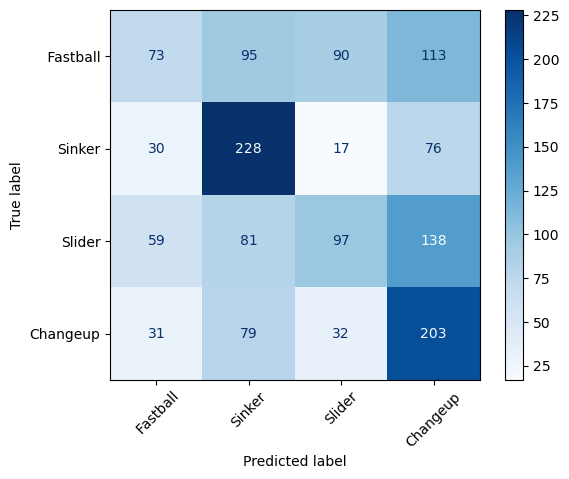

In [95]:
from sklearn.utils.class_weight import compute_class_weight


#Model 1 Multiple logistic regression
lr_model = LogisticRegression(random_state=43, max_iter=10000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_predictions, average='weighted'))


#class_report = classification_report(y_test, lr_predictions, zero_division=0)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
class_labels = df['pitch_type_map'].unique()

# Plotting the detailed confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix with Class Labels')
# plt.show()

print("Classification Report:")
print(classification_report(y_test, lr_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, lr_predictions)

# Convert confusion matrix to a DataFrame with mapped labels
# conf_matrix_df = pd.DataFrame(
#     conf_matrix, 
#     index=[class_mapping[c] for c in np.unique(y)], 
#     columns=[class_mapping[c] for c in np.unique(y)]
# )

# print("\nConfusion Matrix:")
# print(conf_matrix_df)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

# Precision, Recall, and F1-score for each class
# Weighted metrics to consider class frequencies
# Confusion Matrix for deeper insights


Classification Report:
              precision    recall  f1-score   support

    Fastball       0.40      0.22      0.28       371
      Sinker       0.47      0.78      0.59       351
      Slider       0.48      0.19      0.28       375
    Changeup       0.44      0.65      0.53       345

    accuracy                           0.45      1442
   macro avg       0.45      0.46      0.42      1442
weighted avg       0.45      0.45      0.42      1442

KNN F1 Score: 0.41520399050024975


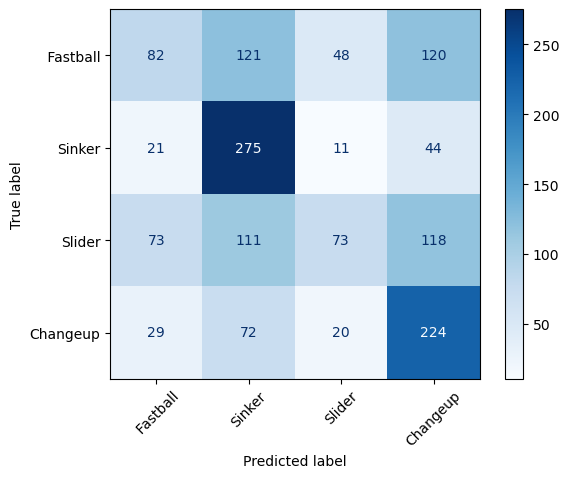

In [102]:
#model 2 KNN
# highest_acc = 0
# highest_f1 = 0
# best_k = 0
# for i in range(1,30):
#     knn_model = KNeighborsClassifier(n_neighbors= i)
#     knn_model.fit(X_train, y_train)
#     knn_predictions = knn_model.predict(X_test)
#     acc =  accuracy_score(y_test, knn_predictions)
#     f1 = f1_score(y_test, knn_predictions, average='weighted')
#     if acc > highest_acc:
#         highest_f1 = f1
#         highest_acc = acc
#         best_k = i
    
#     # print(f"KNN Accuracy for {i}:", accuracy_score(y_test, knn_predictions))

# print('Best K for KNN: ', best_k)
# print('KNN Accuracy: ', highest_acc)
# print('KNN F1 Score: ', highest_acc)
knn_model = KNeighborsClassifier(n_neighbors= 26)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

    
conf_matrix_knn = confusion_matrix(y_test, knn_predictions)
#class_report = classification_report(y_test, lr_predictions, zero_division=0)



print("Classification Report:")
print(classification_report(y_test, knn_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))
class_labels = df['pitch_type_map'].unique()

print("KNN F1 Score:", f1_score(y_test, knn_predictions, average='weighted'))


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

Classification Report:
              precision    recall  f1-score   support

    Fastball       0.53      0.46      0.49       371
      Sinker       0.72      0.80      0.76       351
      Slider       0.53      0.44      0.48       375
    Changeup       0.61      0.75      0.68       345

    accuracy                           0.61      1442
   macro avg       0.60      0.61      0.60      1442
weighted avg       0.60      0.61      0.60      1442

Random Forest Accuracy: 0.6054091539528432
Random Forest F1 Score: 0.5968672488815031


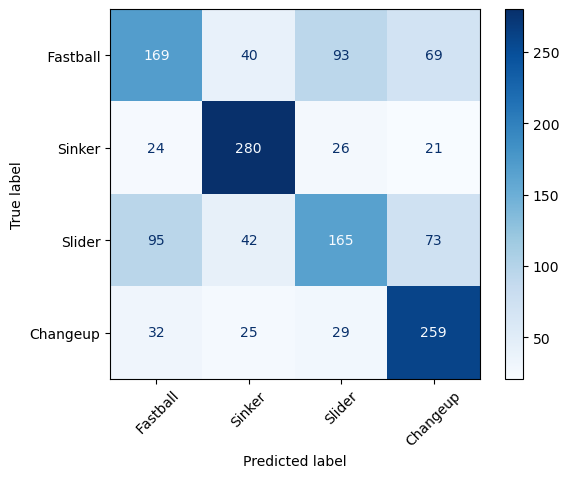

In [103]:

#Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
#Model 3 Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# rf = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }


# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print(f"Best Hyperparameters: {grid_search.best_params_}")


rf_model = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#report
print("Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))

#overall metrics
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest F1 Score:", f1_score(y_test, rf_predictions, average='weighted'))

class_labels = df['pitch_type_map'].unique()

#confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

In [ ]:
#Model 4 XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
xgb = XGBClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=45)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost F1 Score:", f1_score(y_test, xgb_predictions, average='weighted'))

/Users/cstone/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.4098360655737705
XGBoost F1 Score: 0.414385587115755


Validating on some different pitchers

In [77]:
from sklearn.preprocessing import LabelEncoder

df_val = pd.read_csv('/Users/cstone/Documents/Projects/MLB_Pitch_Prediction/data/raw/charlie_morton.csv')


cols = ['balls', 'strikes', 'outs_when_up', 'batter_is_right', 'pitcher_is_right', 'n_thruorder_pitcher', 'pitch_type_map']
df_val = df_val[cols]

Xval = df_val.drop(columns=['pitch_type_map'])
yval = df_val['pitch_type_map']



Xvaltrain, Xvaltest, yvaltrain, yvaltest = train_test_split(Xval, yval, test_size=0.25, random_state=41)
label_encoder = LabelEncoder()
yvaltrain_encoded = label_encoder.fit_transform(yvaltrain)
# Initialize the XGBClassifier
xgb_val_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the model
xgb_val_model.fit(Xvaltrain, yvaltrain_encoded)

# Make predictions
xgb_val_predictions = xgb_val_model.predict(Xvaltest)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(yvaltest, xgb_val_predictions))
print("XGBoost F1 Score:", f1_score(yvaltest, xgb_val_predictions, average='weighted'))

XGBoost Accuracy: 0.4075757575757576
XGBoost F1 Score: 0.36542222858537105


In [ ]:
#Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=10000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

#KNN
highest_acc = 0
highest_f1 = 0
best_k = 0
for i in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors= i)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    acc =  accuracy_score(y_test, knn_predictions)
    f1 = f1_score(y_test, knn_predictions, average='weighted')
    if acc > highest_acc:
        highest_f1 = f1
        highest_acc = acc
        best_k = i


#Random Forest
rf_model = RandomForestClassifier(n_estimators=10000, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluations
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest F1 Score:", f1_score(y_test, rf_predictions, average='weighted'))

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_predictions, average='weighted'))

print('Best K for KNN: ', best_k)
print('KNN Accuracy: ', highest_acc)
print('KNN F1 Score: ', highest_acc)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest F1 Score:", f1_score(y_test, rf_predictions, average='weighted'))


array([0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 2, 0, 3, 0, 3, 3, 3, 4, 3, 3, 3,
       0, 2, 3, 3, 0, 0, 4, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 3, 4, 0, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 4, 3, 1, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       2, 0, 4, 3, 0, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 4, 1, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 2, 3, 2, 0, 3, 3, 3, 0, 3, 3, 0,
       0, 0, 3, 0, 3, 3, 3, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 3, 3, 0, 0, 0, 3,
       3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 3, 0,
       4, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 1, 0, 3, 3, 3, 3, 0, 4, 0,
       0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 0, 0, 3,
       0, 3, 3, 3, 3, 3, 3, 0, 2, 3, 2, 3, 0, 3, 4,

xgb_val_predictions

In [59]:
print("Training classes:", np.unique(yvaltrain))
print("Training classes:", np.unique(yvaltrain_encoded))

print("Testing classes:", np.unique(yvaltest))

Training classes: [0 1 2 3 5]
Training classes: [0 1 2 3 4]
Testing classes: [0 1 2 3 5]


In [ ]:
# Accuracy

# F1-Score

# Confusion Matrice

# ROC Cruve